In [275]:
import pandas as pd
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import plotly.graph_objects as go
import ruptures as rpt
from itertools import combinations as comb
from statsmodels.stats import power
import numpy as np
from scipy import stats
from scipy.signal import find_peaks

from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from scipy.spatial.distance import cdist
import colorsys

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
cpd_model = rpt.Binseg(model = 'l2',jump=500, min_size=4500)
def change_point_detection(df, throw_away = 0.1):
    """
    Changepoint Detection
    Input: - df:  from read_data
           - key: which is the filename
           - throw_away: everything smaller than 10% of the total length of data is thrown away

    Returns: - return_dict: A dictionary with all the data and the format key_cnt
    """
    signal = df[['accelerometer_x','accelerometer_y','accelerometer_z']].values
    length = len(df)
    algo = cpd_model.fit(signal)
    result = [0]
    result += algo.predict(pen=1000)
    if result[-1] != length:
        result += [length]
        
    return_df = pd.DataFrame()
    for i in range(len(result)-1):
        if result[i+1]-result[i] > 4500:
            if return_df.empty:
                return_df = df.iloc[result[i]:result[i+1]]
            else:
                pd.concat([return_df, df.iloc[result[i]:result[i+1]]],ignore_index=True)
            
    """
    This is the seperated version, so we dont have windows that belong to different changepoint sections
    return_dict = {}
    cnt = 1
    for i in range(len(result)-1):
        if result[i+1]-result[i] > length*throw_away:
            return_dict[key+'_'+str(cnt)] = df.iloc[result[i]:result[i+1]]
            cnt+=1
    """
    return return_df

In [51]:
folder_path = 'data'
def read_data(filename):
    accelerometer = pd.read_csv(os.path.join(folder_path, filename, 'Accelerometer.csv'),sep=';')
    accelerometer['Time (s)'] = pd.to_datetime(accelerometer['Time (s)'], unit='s')
    accelerometer =accelerometer.set_index('Time (s)')
    accelerometer = accelerometer.resample('2.5ms').mean()
    accelerometer.rename(columns={'Acceleration x (m/s^2)':'accelerometer_x','Acceleration y (m/s^2)':'accelerometer_y','Acceleration z (m/s^2)':'accelerometer_z'}, inplace=True)
    accelerometer = accelerometer[9000:-9000]
    accelerometer.reset_index(inplace=True)

    
    gyroscope = pd.read_csv(os.path.join(folder_path, filename,'Gyroscope.csv'),sep=';')
    gyroscope['Time (s)'] = pd.to_datetime(gyroscope['Time (s)'], unit='s')
    gyroscope =gyroscope.set_index('Time (s)')
    gyroscope = gyroscope.resample('2.5ms').mean()
    gyroscope.rename(columns={'Gyroscope x (rad/s)':'gyroscope_x','Gyroscope y (rad/s)':'gyroscope_y','Gyroscope z (rad/s)':'gyroscope_z'}, inplace=True)
    gyroscope = gyroscope[9000:-9000]
    gyroscope.reset_index(inplace=True)
    merged = pd.merge(accelerometer,gyroscope, on= 'Time (s)', how='inner')
    # return merged
    return change_point_detection(merged)
    

In [52]:
# regex to delete the number at the end of the string:
def delete_number(string):
    return ''.join([i for i in string if not i.isdigit()])

In [272]:
data_dict = {}
name_to_idx = {} # name -> idx
i = 0

for name in tqdm(sorted(os.listdir(folder_path))):
    data_dict[name] = read_data(name)
    data_dict[name].set_index('Time (s)', inplace=True)
    data_dict[name].interpolate(inplace=True, method="time")

    # add label
    if delete_number(name) not in name_to_idx.keys():
        name_to_idx[delete_number(name)] = i
        i+=1

100%|███████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:15<00:00,  1.08it/s]


In [54]:
def min_max_normalize(df):
    return (df - df.min()) / (df.max() - df.min())

# Apply normalization per person
for key in data_dict.keys():
    data_dict[key] = min_max_normalize(data_dict[key])

In [55]:
def add_feature(axis_list, axis, X_train, appendix=""):
    #mean
    X_train[axis+'_mean'+appendix] = pd.Series(axis_list).apply(lambda x: x.mean())
    #std dev
    X_train[axis+'_std'+appendix] = pd.Series(axis_list).apply(lambda x: x.std())
    #avg absolute difference
    X_train[axis+'_aad'+appendix] = pd.Series(axis_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    #min
    X_train[axis+'_min'+appendix] = pd.Series(axis_list).apply(lambda x: x.min())
    #max
    X_train[axis+'_max'+appendix] = pd.Series(axis_list).apply(lambda x: x.max())
    #max-min diff
    X_train[axis+'_maxmin_diff'+appendix] = X_train[axis+'_max'+appendix] - X_train[axis+'_min'+appendix]
    #median
    X_train[axis+'_median'+appendix] = pd.Series(axis_list).apply(lambda x: np.median(x))
    #median absolut deviation
    X_train[axis+'_mad'+appendix] = pd.Series(axis_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    #interquartile range
    X_train[axis+'_IQR'+appendix] = pd.Series(axis_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    if appendix != "_fft":
        #negative count
        X_train[axis+'_neg_count'+appendix] = pd.Series(axis_list).apply(lambda x: np.sum(x < 0))
        #positive count
        X_train[axis+'_pos_count'+appendix] = pd.Series(axis_list).apply(lambda x: np.sum(x > 0))
    
    #values above mean
    X_train[axis+'_above_mean'+appendix] = pd.Series(axis_list).apply(lambda x: np.sum(x > x.mean()))
    #number of peaks
    X_train[axis+'_peak_count'+appendix] = pd.Series(axis_list).apply(lambda x: len(find_peaks(x)[0]))
    #skewness
    X_train[axis+'_skewness'+appendix] = pd.Series(axis_list).apply(lambda x: stats.skew(x))
    #kurtosis
    X_train[axis+'_kurtosis'+appendix] = pd.Series(axis_list).apply(lambda x: stats.kurtosis(x))
    # energy
    X_train[axis+'_energy'+appendix] = pd.Series(axis_list).apply(lambda x: np.sum(x**2)/100)

    return X_train

In [56]:
verification_keys = [] # "nick2", "till2", "uta2", "paula2"

In [96]:
name_to_idx

{'till': 0,
 'nele': 1,
 'lucas': 2,
 'leon': 3,
 'katarina': 4,
 'felix': 5,
 'chris': 6,
 'paula': 7,
 'nick': 8,
 'luisa': 9,
 'rebecca': 10,
 'uta': 11}

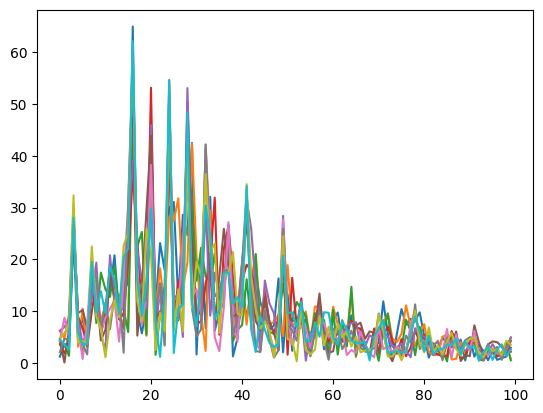

In [215]:
# fft results => we would need 100+ features for the fft (if we don't add the feature aggregations of it) 
for i in range(10):
    plt.plot(x_fft_list[i][:100])


In [58]:
# Initializing lists
x_list = []
y_list = []
z_list = []

x_val_list = []
y_val_list = []
z_val_list = []
val_labels = []

train_labels = []
x_test_list = []
y_test_list = []
z_test_list = []
test_labels = []

gx_list = []
gy_list = []
gz_list = []

gx_val_list = []
gy_val_list = []
gz_val_list = []

gx_test_list = []
gy_test_list = []
gz_test_list = []

window_size = 410 * 5 # we give the model 5 steps
step_size = 410 # 82

# Creating overlapping windows of size window_size
for name, df_train in data_dict.items():
    label = name_to_idx[delete_number(name)]
    n_train_end = int(df_train.shape[0] * 0.7)  # 70% train
    n_test_end = int(df_train.shape[0] * 0.85)  # next 15% test (and the last 15% for val)

    # Training data
    for i in range(0, n_train_end - window_size, step_size):
        xs = df_train['accelerometer_x'].values[i: i + window_size]
        ys = df_train['accelerometer_y'].values[i: i + window_size]
        zs = df_train['accelerometer_z'].values[i: i + window_size]
        x_list.append(xs)
        y_list.append(ys)
        z_list.append(zs)
        train_labels.append(label)
        
        gxs = df_train['gyroscope_x'].values[i: i + window_size]
        gys = df_train['gyroscope_y'].values[i: i + window_size]
        gzs = df_train['gyroscope_z'].values[i: i + window_size]
        gx_list.append(gxs)
        gy_list.append(gys)
        gz_list.append(gzs)
    
    # Testing data
    for i in range(n_train_end, n_test_end - window_size, step_size):
        xs = df_train['accelerometer_x'].values[i: i + window_size]
        ys = df_train['accelerometer_y'].values[i: i + window_size]
        zs = df_train['accelerometer_z'].values[i: i + window_size]
        x_test_list.append(xs)
        y_test_list.append(ys)
        z_test_list.append(zs)
        test_labels.append(label)

        gxs = df_train['gyroscope_x'].values[i: i + window_size]
        gys = df_train['gyroscope_y'].values[i: i + window_size]
        gzs = df_train['gyroscope_z'].values[i: i + window_size]
        gx_test_list.append(gxs)
        gy_test_list.append(gys)
        gz_test_list.append(gzs)

    # Validation data
    for i in range(n_test_end, df_train.shape[0] - window_size, step_size):
        xs = df_train['accelerometer_x'].values[i: i + window_size]
        ys = df_train['accelerometer_y'].values[i: i + window_size]
        zs = df_train['accelerometer_z'].values[i: i + window_size]
        x_val_list.append(xs)
        y_val_list.append(ys)
        z_val_list.append(zs)
        val_labels.append(label)

        gxs = df_train['gyroscope_x'].values[i: i + window_size]
        gys = df_train['gyroscope_y'].values[i: i + window_size]
        gzs = df_train['gyroscope_z'].values[i: i + window_size]
        gx_val_list.append(gxs)
        gy_val_list.append(gys)
        gz_val_list.append(gzs)

def calculate_magnitude_mean(x_list, y_list, z_list):
    return [((pd.Series(x_list[i])**2 + pd.Series(y_list[i])**2 + pd.Series(z_list[i])**2)**0.5).mean() for i in range(len(x_list))]

def calculate_sma(x_list, y_list, z_list):
    """ Calculates the signal magnitude area. """
    return (pd.Series(x_list).apply(lambda x: np.sum(abs(x)/window_size)) +
            pd.Series(y_list).apply(lambda x: np.sum(abs(x)/window_size)) +
            pd.Series(z_list).apply(lambda x: np.sum(abs(x)/window_size)))

def calculate_fft_features(data_list, prefix, df):
    fft_list = pd.Series(data_list).apply(lambda x: np.abs(np.fft.fft(x))[1:window_size//2+1])
    df = add_feature(fft_list, prefix, df, "_fft")
    return df, fft_list

# Train
X_train = pd.DataFrame()
X_train = add_feature(x_list, 'x', X_train)
X_train = add_feature(y_list, 'y', X_train)
X_train = add_feature(z_list, 'z', X_train)
X_train['avg_result_accl'] = calculate_magnitude_mean(x_list, y_list, z_list)
X_train['sma'] = calculate_sma(x_list, y_list, z_list)
X_train, x_fft_list = calculate_fft_features(x_list, 'x', X_train)
X_train, y_fft_list = calculate_fft_features(y_list, 'y', X_train)
X_train, z_fft_list = calculate_fft_features(z_list, 'z', X_train)
X_train['avg_result_accl_fft'] = calculate_magnitude_mean(x_fft_list, y_fft_list, z_fft_list)
X_train['sma_fft'] = calculate_sma(x_fft_list, y_fft_list, z_fft_list)

X_train = add_feature(gx_list, 'gx', X_train)
X_train = add_feature(gy_list, 'gy', X_train)
X_train = add_feature(gz_list, 'gz', X_train)
X_train['avg_result_gyro'] = calculate_magnitude_mean(gx_list, gy_list, gz_list)
X_train['sma_gyro'] = calculate_sma(gx_list, gy_list, gz_list)
X_train, gx_fft_list = calculate_fft_features(gx_list, 'gx', X_train)
X_train, gy_fft_list = calculate_fft_features(gy_list, 'gy', X_train)
X_train, gz_fft_list = calculate_fft_features(gz_list, 'gz', X_train)
X_train['avg_result_gyro_fft'] = calculate_magnitude_mean(gx_fft_list, gy_fft_list, gz_fft_list)
X_train['sma_gyro_fft'] = calculate_sma(gx_fft_list, gy_fft_list, gz_fft_list)

y_train = np.array(train_labels)

# Validation
X_val = pd.DataFrame()
X_val = add_feature(x_val_list, 'x', X_val)
X_val = add_feature(y_val_list, 'y', X_val)
X_val = add_feature(z_val_list, 'z', X_val)
X_val['avg_result_accl'] = calculate_magnitude_mean(x_val_list, y_val_list, z_val_list)
X_val['sma'] = calculate_sma(x_val_list, y_val_list, z_val_list)
X_val, x_val_fft_list = calculate_fft_features(x_val_list, 'x', X_val)
X_val, y_val_fft_list = calculate_fft_features(y_val_list, 'y', X_val)
X_val, z_val_fft_list = calculate_fft_features(z_val_list, 'z', X_val)
X_val['avg_result_accl_fft'] = calculate_magnitude_mean(x_val_fft_list, y_val_fft_list, z_val_fft_list)
X_val['sma_fft'] = calculate_sma(x_val_fft_list, y_val_fft_list, z_val_fft_list)

X_val = add_feature(gx_val_list, 'gx', X_val)
X_val = add_feature(gy_val_list, 'gy', X_val)
X_val = add_feature(gz_val_list, 'gz', X_val)
X_val['avg_result_gyro'] = calculate_magnitude_mean(gx_val_list, gy_val_list, gz_val_list)
X_val['sma_gyro'] = calculate_sma(gx_val_list, gy_val_list, gz_val_list)
X_val, gx_val_fft_list = calculate_fft_features(gx_val_list, 'gx', X_val)
X_val, gy_val_fft_list = calculate_fft_features(gy_val_list, 'gy', X_val)
X_val, gz_val_fft_list = calculate_fft_features(gz_val_list, 'gz', X_val)
X_val['avg_result_gyro_fft'] = calculate_magnitude_mean(gx_val_fft_list, gy_val_fft_list, gz_val_fft_list)
X_val['sma_gyro_fft'] = calculate_sma(gx_val_fft_list, gy_val_fft_list, gz_val_fft_list)

y_val = np.array(val_labels)

# Test
X_test = pd.DataFrame()
X_test = add_feature(x_test_list, 'x', X_test)
X_test = add_feature(y_test_list, 'y', X_test)
X_test = add_feature(z_test_list, 'z', X_test)
X_test['avg_result_accl'] = calculate_magnitude_mean(x_test_list, y_test_list, z_test_list)
X_test['sma'] = calculate_sma(x_test_list, y_test_list, z_test_list)
X_test, x_test_fft_list = calculate_fft_features(x_test_list, 'x', X_test)
X_test, y_test_fft_list = calculate_fft_features(y_test_list, 'y', X_test)
X_test, z_test_fft_list = calculate_fft_features(z_test_list, 'z', X_test)
X_test['avg_result_accl_fft'] = calculate_magnitude_mean(x_test_fft_list, y_test_fft_list, z_test_fft_list)
X_test['sma_fft'] = calculate_sma(x_test_fft_list, y_test_fft_list, z_test_fft_list)

X_test = add_feature(gx_test_list, 'gx', X_test)
X_test = add_feature(gy_test_list, 'gy', X_test)
X_test = add_feature(gz_test_list, 'gz', X_test)
X_test['avg_result_gyro'] = calculate_magnitude_mean(gx_test_list, gy_test_list, gz_test_list)
X_test['sma_gyro'] = calculate_sma(gx_test_list, gy_test_list, gz_test_list)
X_test, gx_test_fft_list = calculate_fft_features(gx_test_list, 'gx', X_test)
X_test, gy_test_fft_list = calculate_fft_features(gy_test_list, 'gy', X_test)
X_test, gz_test_fft_list = calculate_fft_features(gz_test_list, 'gz', X_test)
X_test['avg_result_gyro_fft'] = calculate_magnitude_mean(gx_test_fft_list, gy_test_fft_list, gz_test_fft_list)
X_test['sma_gyro_fft'] = calculate_sma(gx_test_fft_list, gy_test_fft_list, gz_test_fft_list)

y_test = np.array(test_labels)

# Shuffle the training set
X_train, y_train = shuffle(X_train, y_train, random_state=42)

print('Train:', X_train.shape, y_train.shape)
print('Val:', X_val.shape, y_val.shape)
print('Test:', X_test.shape, y_test.shape)


Train: (3825, 188) (3825,)
Val: (761, 188) (761,)
Test: (761, 188) (761,)


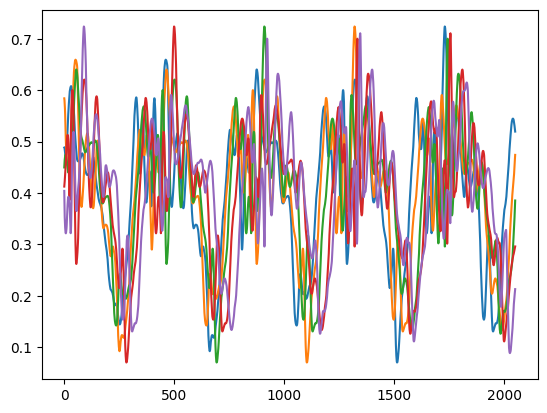

In [115]:
for i in range(5):
    plt.plot(df_train['gyroscope_x'].values[410*i : 410*i + 410 * 5])

## XGBoost

In [60]:
model = xgb.XGBClassifier(eval_metric='mlogloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

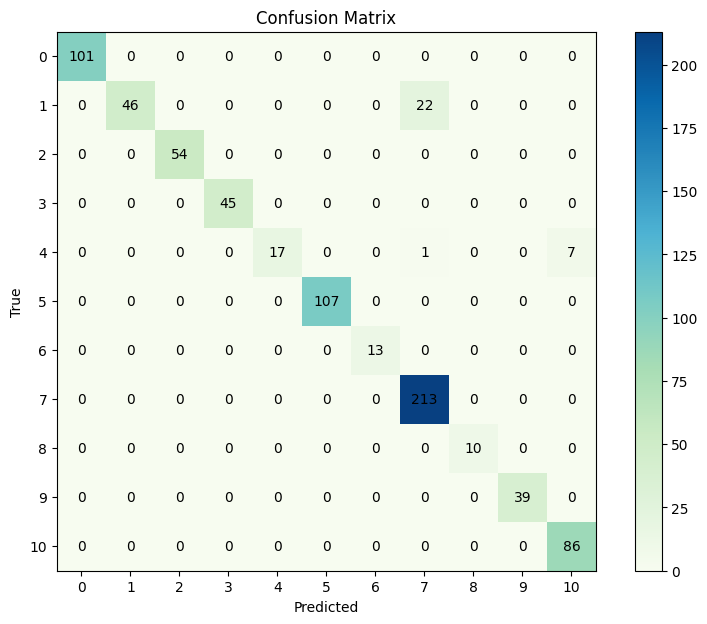

In [85]:
# Compute the confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 7))
cax = ax.matshow(cm, cmap='GnBu') # Blues
fig.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(np.arange(cm.shape[0]))
ax.set_yticklabels(np.arange(cm.shape[1]))
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted')
plt.ylabel('True')


# Add annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.title('Confusion Matrix')
plt.show()

<Axes: >

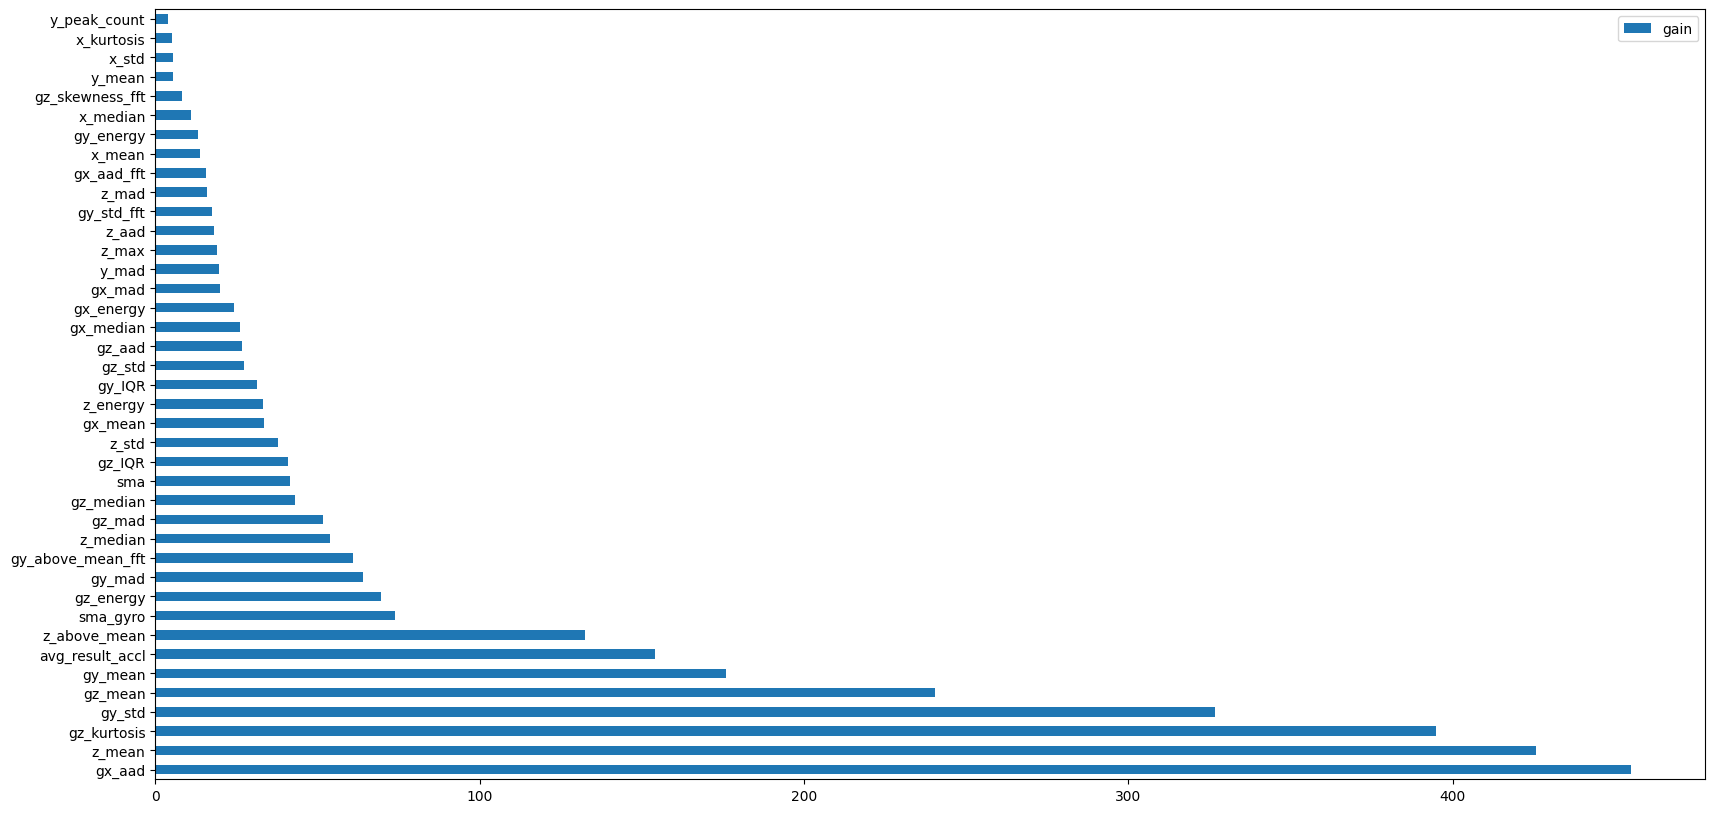

In [90]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["gain"]).sort_values(by = "gain", ascending=False)
data.nlargest(40, columns="gain").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [95]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.68      0.81        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       1.00      0.68      0.81        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           8       0.90      1.00      0.95       213
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        39
          11       0.92      1.00      0.96        86

    accuracy                           0.96       761
   macro avg       0.98      0.94      0.96       761
weighted avg       0.96      0.96      0.96       761



## Logistic Regression

In [265]:
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga', C=0.05, random_state = 21)
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9921156373193167

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.91      0.95        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       1.00      1.00      1.00        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           8       0.97      1.00      0.99       213
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        39
          11       1.00      1.00      1.00        86

    accuracy                           0.99       761
   macro avg       1.00      0.99      0.99       761
weighted avg       0.99      0.99      0.99       761



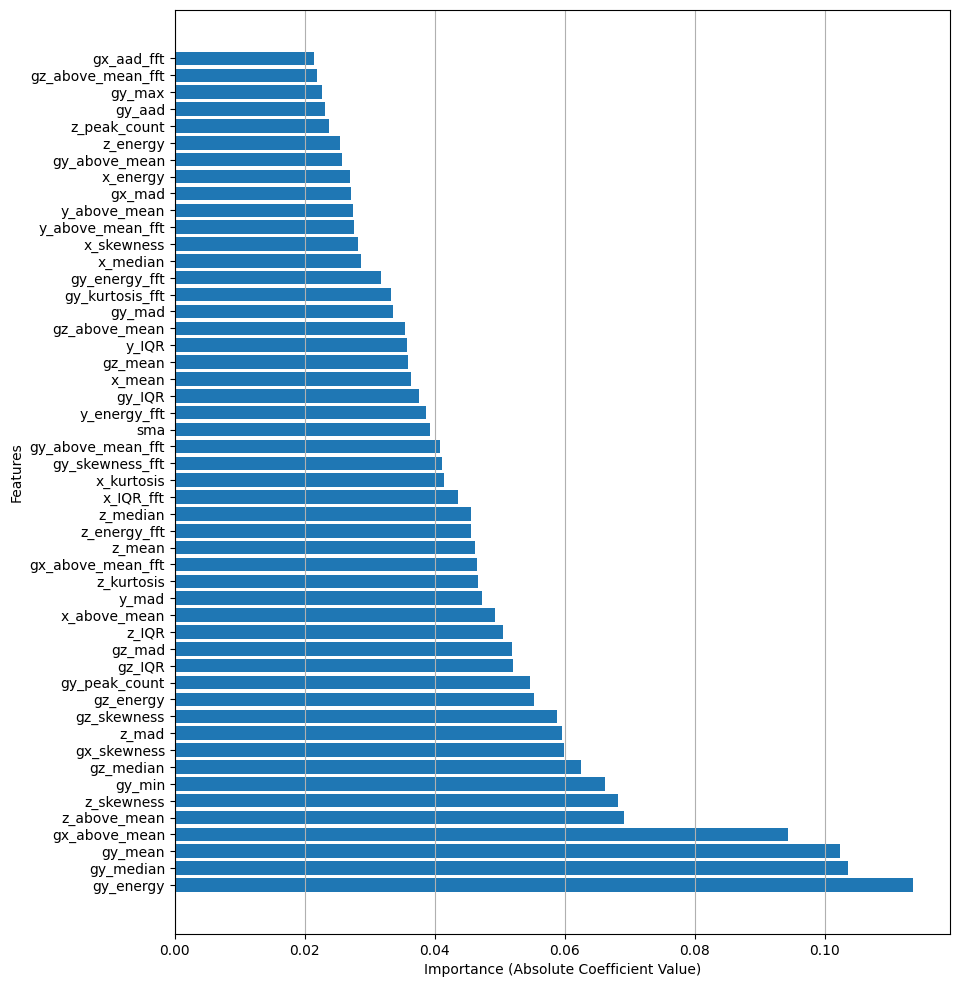

Feature: gy_energy, Coefficient: 0.11355462583864707, Importance: 0.11355462583864707
Feature: gy_median, Coefficient: 0.10359312909362188, Importance: 0.10359312909362188
Feature: gy_mean, Coefficient: 0.10237468094140016, Importance: 0.10237468094140016
Feature: gx_above_mean, Coefficient: 0.09432524347222443, Importance: 0.09432524347222443
Feature: z_above_mean, Coefficient: 0.06916263452649542, Importance: 0.06916263452649542
Feature: z_skewness, Coefficient: 0.06825743324273609, Importance: 0.06825743324273609
Feature: gy_min, Coefficient: 0.06624691660685786, Importance: 0.06624691660685786
Feature: gz_median, Coefficient: 0.06244933369027068, Importance: 0.06244933369027068
Feature: gx_skewness, Coefficient: 0.05987859908973412, Importance: 0.05987859908973412
Feature: z_mad, Coefficient: 0.059540604970432794, Importance: 0.059540604970432794
Feature: gz_skewness, Coefficient: 0.058829749676012406, Importance: 0.058829749676012406
Feature: gz_energy, Coefficient: 0.055256486522

In [266]:
# Feature importance
feature_names = X_train.columns
coefficients = np.abs(lr.coef_).mean(0)
importance = np.abs(coefficients)

# Sort features by importance
sorted_indices = np.argsort(importance)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_coefficients = coefficients[sorted_indices]
sorted_importance = importance[sorted_indices]

# Select top 40 features
top_n = 50 # 188
top_features = sorted_features[:top_n]
top_coefficients = sorted_coefficients[:top_n]
top_importance = sorted_importance[:top_n]

# Create horizontal bar chart
plt.figure(figsize=(10, 12))
plt.barh(range(len(top_features)), top_importance, tick_label=top_features)
plt.xlabel('Importance (Absolute Coefficient Value)')
plt.ylabel('Features')
#plt.title('Top 40 Feature Importance in Logistic Regression')
plt.grid(axis='x')
plt.show()

for feature, coef, imp in zip(top_features, top_coefficients, top_importance):
    print(f"Feature: {feature}, Coefficient: {coef}, Importance: {imp}")

## Train with less features (Occams Razor)

In [286]:
lr = LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga', C=0.001, random_state=21)
lr.fit(np.array(X_train[top_features]), y_train)

y_pred = lr.predict(np.array(X_test[top_features]))
print(classification_report(y_test, y_pred))
f1_score(y_test, y_pred, average='weighted')

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       1.00      0.44      0.61        25
           5       0.96      1.00      0.98       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.91      0.94      0.93       213
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        39
          11       1.00      1.00      1.00        86

    accuracy                           0.96       761
   macro avg       0.90      0.86      0.87       761
weighted avg       0.97      0.96      0.96       761



0.9592530667081126

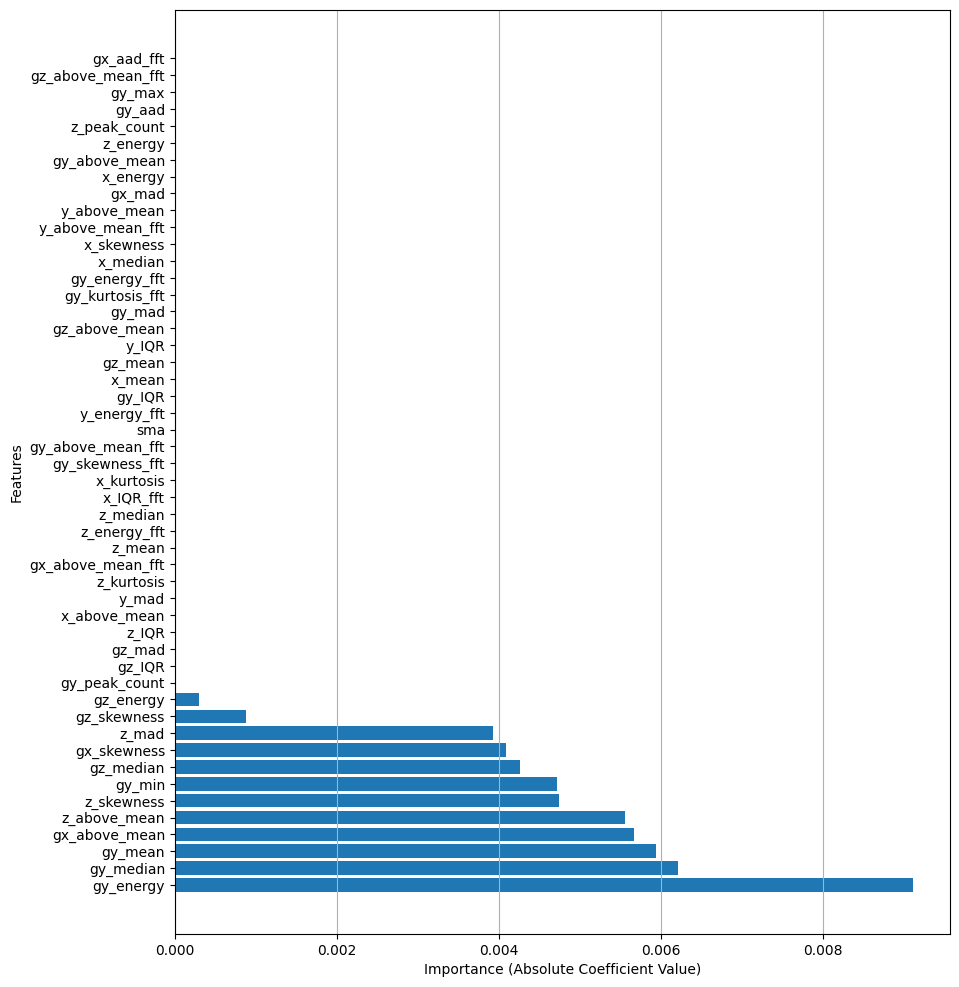

Feature: gy_energy, Coefficient: 0.009114879043463904, Importance: 0.009114879043463904
Feature: gy_median, Coefficient: 0.006211526831292307, Importance: 0.006211526831292307
Feature: gy_mean, Coefficient: 0.00594102907145111, Importance: 0.00594102907145111
Feature: gx_above_mean, Coefficient: 0.005666791442767043, Importance: 0.005666791442767043
Feature: z_above_mean, Coefficient: 0.005555244816393985, Importance: 0.005555244816393985
Feature: z_skewness, Coefficient: 0.004749115620193087, Importance: 0.004749115620193087
Feature: gy_min, Coefficient: 0.0047249182916928026, Importance: 0.0047249182916928026
Feature: gz_median, Coefficient: 0.0042652944788453525, Importance: 0.0042652944788453525
Feature: gx_skewness, Coefficient: 0.004091510147924793, Importance: 0.004091510147924793
Feature: z_mad, Coefficient: 0.003925344475650579, Importance: 0.003925344475650579
Feature: gz_skewness, Coefficient: 0.0008795046265979412, Importance: 0.0008795046265979412
Feature: gz_energy, Coeff

In [287]:
# Feature importance
feature_names = X_train.columns
coefficients = np.abs(lr.coef_).mean(0)
importance = np.abs(coefficients)

# Sort features by importance
sorted_indices = np.argsort(importance)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_coefficients = coefficients[sorted_indices]
sorted_importance = importance[sorted_indices]

# Select top 40 features
top_n = 50 # 188
top_features_ = sorted_features[:top_n]
top_coefficients = sorted_coefficients[:top_n]
top_importance = sorted_importance[:top_n]

# Create horizontal bar chart
plt.figure(figsize=(10, 12))
plt.barh(range(len(top_features_)), top_importance, tick_label=top_features)
plt.xlabel('Importance (Absolute Coefficient Value)')
plt.ylabel('Features')
#plt.title('Top 40 Feature Importance in Logistic Regression')
plt.grid(axis='x')
plt.show()

for feature, coef, imp in zip(top_features, top_coefficients, top_importance):
    print(f"Feature: {feature}, Coefficient: {coef}, Importance: {imp}")

## Tuning

In [278]:
import wandb

In [285]:
def train_evaluate(config=None):
    with wandb.init(config=config):
        config = wandb.config

        lr = LogisticRegression(
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            C=config.C,
            random_state=42
        )
        lr.fit(np.array(X_train[top_features]), y_train)
        
        y_pred = lr.predict(np.array(X_val[top_features]))
        val_f1 = f1_score(y_val, y_pred, average='weighted')
        
        wandb.log({"val_f1": val_f1})
        print(classification_report(y_val, y_pred))


sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_f1',
        'goal': 'maximize'
    },
    'parameters': {
        'C': {
            'distribution': 'log_uniform_values',
            'min': 0.0001,
            'max': 1.0
        }
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, entity='ds4w', project='ds4w')
wandb.agent(sweep_id, function=train_evaluate, count=30)

Create sweep with ID: vfjumq0e
Sweep URL: https://wandb.ai/ds4w/ds4w/sweeps/vfjumq0e


wandb: Agent Starting Run: eni2rs2c with config:
wandb: 	C: 0.10244752418181428


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mh8hxqdn with config:
wandb: 	C: 0.009492809277979075


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3pw67hid with config:
wandb: 	C: 0.003953814544660583


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.95      0.96       213
           9       0.78      0.70      0.74        10
          10       0.89      1.00      0.94        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.88      0.88      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97816


wandb: Agent Starting Run: u0xz2lwf with config:
wandb: 	C: 0.03609408737066498


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Agent Starting Run: qxvv0djy with config:
wandb: 	C: 0.001872831608753394


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.96      0.97       213
           9       1.00      0.70      0.82        10
          10       0.91      1.00      0.95        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.90      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97991


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: je9vzrgo with config:
wandb: 	C: 0.0015828411637242947


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.96      0.97       213
           9       1.00      0.70      0.82        10
          10       0.93      1.00      0.96        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.90      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.9812


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 06y61frn with config:
wandb: 	C: 0.00014119282426796904


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       101
           1       0.98      0.87      0.92        68
           2       1.00      0.96      0.98        54
           3       1.00      1.00      1.00        45
           4       1.00      0.76      0.86        25
           5       0.98      1.00      0.99       107
           6       1.00      1.00      1.00        13
           8       0.92      0.96      0.94       213
           9       0.75      0.60      0.67        10
          10       0.97      1.00      0.99        39
          11       0.99      1.00      0.99        86

    accuracy                           0.96       761
   macro avg       0.96      0.92      0.94       761
weighted avg       0.96      0.96      0.96       761



val_f1,▁
val_f1,0.96095


wandb: Agent Starting Run: ollzuq52 with config:
wandb: 	C: 0.928104548435592


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ks4ahuth with config:
wandb: 	C: 0.0011218687557745413


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       1.00      1.00      1.00        25
           5       0.98      1.00      0.99       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.97      0.97      0.97       213
           9       1.00      0.70      0.82        10
          10       0.93      1.00      0.96        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.91      0.88      0.89       761
weighted avg       0.99      0.98      0.98       761



val_f1,▁
val_f1,0.98319


wandb: Agent Starting Run: l4pza27p with config:
wandb: 	C: 0.000890253939365445


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       101
           1       0.98      0.93      0.95        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       1.00      0.96      0.98        25
           5       0.98      1.00      0.99       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.97      0.97      0.97       213
           9       1.00      0.70      0.82        10
          10       0.95      1.00      0.97        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.91      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.98051


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: idx8yzg0 with config:
wandb: 	C: 0.001653507274963952


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.96      0.97       213
           9       1.00      0.70      0.82        10
          10       0.91      1.00      0.95        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.90      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97991


wandb: Agent Starting Run: oypqfkfc with config:
wandb: 	C: 0.10914996707591


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tgnys8hy with config:
wandb: 	C: 0.002126440400236395


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.96      0.97       213
           9       1.00      0.70      0.82        10
          10       0.89      1.00      0.94        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.90      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97933


wandb: Agent Starting Run: 7lkedink with config:
wandb: 	C: 0.006073779838944279


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.70      0.70      0.70        10
          10       0.89      1.00      0.94        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.87      0.88      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97698


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b7yfrtfj with config:
wandb: 	C: 0.0020807721389171515


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.96      0.97       213
           9       1.00      0.70      0.82        10
          10       0.89      1.00      0.94        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.90      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97933


wandb: Agent Starting Run: pguv2634 with config:
wandb: 	C: 0.7310716371996069


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z0yuh2px with config:
wandb: 	C: 0.000917011800531729


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       101
           1       0.98      0.93      0.95        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       1.00      0.96      0.98        25
           5       0.98      1.00      0.99       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.97      0.97      0.97       213
           9       1.00      0.70      0.82        10
          10       0.95      1.00      0.97        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.91      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.98051


wandb: Agent Starting Run: fuemxs85 with config:
wandb: 	C: 0.02819254345486232


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 65re2uy3 with config:
wandb: 	C: 0.0005144572370019174


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       101
           1       0.98      0.90      0.94        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       1.00      0.96      0.98        25
           5       0.97      1.00      0.99       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.96      0.98      0.97       213
           9       1.00      0.70      0.82        10
          10       1.00      1.00      1.00        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.91      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.98043


wandb: Agent Starting Run: bdg3ahno with config:
wandb: 	C: 0.00010387031057925876


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       101
           1       0.87      0.81      0.84        68
           2       0.98      0.94      0.96        54
           3       1.00      1.00      1.00        45
           4       1.00      0.64      0.78        25
           5       0.98      1.00      0.99       107
           6       1.00      1.00      1.00        13
           8       0.89      0.93      0.91       213
           9       1.00      0.40      0.57        10
          10       0.95      1.00      0.97        39
          11       0.98      1.00      0.99        86

    accuracy                           0.94       761
   macro avg       0.96      0.88      0.91       761
weighted avg       0.94      0.94      0.94       761



val_f1,▁
val_f1,0.93673


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mbgcv8tv with config:
wandb: 	C: 0.005038251631365378


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.70      0.70      0.70        10
          10       0.89      1.00      0.94        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.87      0.88      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97698


wandb: Agent Starting Run: oy8ngukj with config:
wandb: 	C: 0.0002969604454539146


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       101
           1       0.98      0.88      0.93        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       1.00      0.92      0.96        25
           5       0.98      1.00      0.99       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.95      0.98      0.96       213
           9       1.00      0.70      0.82        10
          10       1.00      1.00      1.00        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.91      0.87      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97711


wandb: Agent Starting Run: m2wfpdq8 with config:
wandb: 	C: 0.12251224740289764


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jh4mye06 with config:
wandb: 	C: 0.0024026256509371


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.96      0.97       213
           9       1.00      0.70      0.82        10
          10       0.89      1.00      0.94        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.90      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.98067


wandb: Agent Starting Run: kui170a9 with config:
wandb: 	C: 0.5979610588182281


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 121rw2r4 with config:
wandb: 	C: 0.001586937025947154


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.96      0.97       213
           9       1.00      0.70      0.82        10
          10       0.93      1.00      0.96        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.90      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.9812


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4pgqnbw6 with config:
wandb: 	C: 0.7308061006723315


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Agent Starting Run: fed6v7f7 with config:
wandb: 	C: 0.2729599911471942


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rg4791ua with config:
wandb: 	C: 0.016072938230801474


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3r90n403 with config:
wandb: 	C: 0.05999797385688894


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


In [ ]:
# best C: 0.001